In [1]:
import os
import numpy as np
import mdtraj as md
import pickle
from simtk.openmm import unit
from tqdm import tqdm_notebook
from simtk.openmm import app
import matplotlib.pyplot as plt
from openeye import oechem
from pymbar import timeseries
import math

from scipy.stats import linregress


In [2]:
def make_traj(phase, out_dir, sub_dir, htf, state=None, replica_id=None, n_iterations_start=None, n_iterations_end=None):
    """
    Retrieve pdbs/dcds of the old and new positions for a given thermodynamic state index or replica id. 
    
    Adapted from Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
    
    Parameters
    ----------
    phase : str
        phase of simulation (e.g., 'complex')
    out_dir : str
        path to directory containing data to analyze
    sub_dir : str
        path to sub-directory containing data to analyze
    htf : perses.annihilation.relative.RESTCapableHybridTopologyFactory
        hybrid topology factory containing hybrid topology, positions, system
    state : int, default None
        state index
    replica_id : int, default None
        replica id
    n_iterations_start : int, default None
        iteration to start the trajectory
    n_iterations_end : int, default None
        iteration to end the trajectory
        
    """
    from simtk.openmm import unit, app
    from tqdm import tqdm_notebook

    import os
    import pickle
    import mdtraj as md
    import numpy as np
    
    # Create mdtraj topologies that correspond to the positions we want to create trajectories for
    new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
    old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)
    
    # Load nc files
    from perses.analysis.utils import open_netcdf
    nc = open_netcdf(os.path.join(out_dir, f"{sub_dir}_{phase}.nc"))
    nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{sub_dir}_{phase}_checkpoint.nc"))
    checkpoint_interval = nc_checkpoint.CheckpointInterval
    all_positions = nc_checkpoint.variables['positions']
    box_vectors = np.array(nc_checkpoint['box_vectors'])
    n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)
    n_iterations_start = 0 if n_iterations_start is None else int(n_iterations_start / checkpoint_interval) + 1
    n_iterations_end = n_iter if n_iterations_end is None else int(n_iterations_end / checkpoint_interval) + 1
    n_iterations = n_iterations_end - n_iterations_start
    print(n_iterations_start, n_iterations_end)
    
    # Retrieve positions 
    all_pos_new = np.zeros(shape=(n_iterations, new_top.n_atoms, 3))
    all_pos_old = np.zeros(shape=(n_iterations, old_top.n_atoms, 3))
    all_box_vectors = np.zeros(shape=(n_iterations, 3, 3), dtype=np.float32)
    for iteration in tqdm_notebook(range(n_iterations_start, n_iterations_end)):
        if state is not None:
            replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == state)[0][0]
        print(replica_id)
        pos = all_positions[iteration,replica_id,:,:] *unit.nanometers
        all_pos_new[iteration-n_iterations_start] = htf.new_positions(pos).value_in_unit_system(unit.md_unit_system)
        all_pos_old[iteration-n_iterations_start] = htf.old_positions(pos).value_in_unit_system(unit.md_unit_system)
        all_box_vectors[iteration-n_iterations_start] = box_vectors[iteration,replica_id,:,:]
    
    # Create trajectories
    traj_old = md.Trajectory(all_pos_old, old_top)
    traj_new = md.Trajectory(all_pos_new, new_top)
    
    # Set unit cell vectors in traj 
    traj_old.unitcell_vectors = all_box_vectors
    traj_new.unitcell_vectors = all_box_vectors
    
    # Save old trajectory
    print("saving old traj")
    traj_old.save(os.path.join(out_dir, f"{sub_dir}_{phase}_old_replica_{replica_id}_{n_iterations_start}_{n_iterations_end}_no_imaging.dcd"))
    traj_old[0].save(os.path.join(out_dir, f"{sub_dir}_{phase}_old_replica_{replica_id}_{n_iterations_start}_{n_iterations_end}_no_imaging.pdb"))
    
    # Save new trajectory
    print("saving new traj")
    traj_new.save(os.path.join(out_dir, f"{sub_dir}_{phase}_new_replica_{replica_id}_{n_iterations_start}_{n_iterations_end}_no_imaging.dcd"))
    traj_new[0].save(os.path.join(out_dir, f"{sub_dir}_{phase}_new_replica_{replica_id}_{n_iterations_start}_{n_iterations_end}_no_imaging.pdb"))

In [10]:
def check_phi_psi_sampling(out_dir, sub_dir, phase, 
                           n_replicas, 
                           n_iterations_start, n_iterations_end, 
                           plot_name, y_range=None):
    
    """
    Parameters
    ----------
    out_dir : str
        path to directory containing data to analyze
    sub_dir : str
        path to sub-directory containing data to analyze
    phase : str
        phase of simulation (e.g., 'complex')
    n_replicas : int
        number of replicas used in the simulation
    n_iterations_start : int, default None
        start iteration (used to load the trajectory)
    n_iterations_end : int, default None
        end iteration (used to load the trajectory)
    plot_name : str
        title of plot
    y_range : list of floats, default None
        range for the y axis
    """
    
    from mdtraj import compute_phi, compute_psi
    
    # Retrieve angles
    labels = ["phi", "psi"]
    angles_all = [[],[]]
    for replica in range(n_replicas):
        
        pdb = md.load(os.path.join(out_dir, f"{sub_dir}_{phase}_old_replica_{replica}_{n_iterations_start}_{n_iterations_end}_no_imaging.pdb"))
        traj = md.load_dcd(os.path.join(out_dir, f"{sub_dir}_{phase}_old_replica_{replica}_{n_iterations_start}_{n_iterations_end}_no_imaging.dcd"), top=pdb)
        
        for angle_type_index, compute_angle in enumerate([compute_phi, compute_psi]):

            # Get angle indices and angle values for each iteration
            indices, angles = compute_angle(traj)
            
            # Figure out which angle corresponds to the phi/psi angle of residue id 2
            angle_index = None
            for angle_index, angle_indices in enumerate(indices):
                resSeqs = [atom.residue.resSeq for atom in pdb.topology.atoms if atom.index in angle_indices]
                if resSeqs.count(2) == 3:
                    desired_angle_index = angle_index
                    break
            if angle_index is None:
                raise Exception(f"{labels[angle_type_index]} angle for residue with resid 2 not found!")
            
            angles = angles[:, angle_index]
            angles_all[angle_type_index].append(angles)
            
    # Plot
    for angle_type_index, angles in enumerate(angles_all):

        # Set figure size
        fig, axes = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=(12, 7))
        fig.subplots_adjust(top=0.7) # The position of the top edge of the subplots, as a fraction of the figure height.

        # Set font size
        plt.rc('font', size=20) 

        # Plot angles
        angles_sin = np.sin(angles)
        y = np.ndarray.flatten(np.array(angles_sin))
        plt.scatter(range(len(y)), y, color="gray", alpha=0.7, s=60)

        # Add lines separating data for each replica
        for replica in range(n_replicas + 1):
            plt.axvline(x=n_iterations_end*(replica), alpha=0.9, linestyle='dotted')
            if replica < n_replicas:
                plt.text(n_iterations_end*(replica + 1) - 60, 1.1, f'replica {replica}', rotation=45)  
        
        # Set axis labels
        plt.ylabel(f"sin({labels[angle_type_index]} angle)")
        plt.xlabel("t (ns)")
        
        # Add titles
        g_regex = r"$g$"
        g_t = round(timeseries.statisticalInefficiencyMultiple(angles_sin)/10, 2)
        plt.suptitle(f"{g_regex}: {g_t} ns", fontsize=20, x=0.54, y=0.72)
        plt.title(plot_name, y=1.53)
        
        # Set tick labels
        if y_range:
            plt.yticks(np.arange(y_range[0], y_range[1], 0.5))
        length = int((n_iterations_end - n_iterations_start) * 100 / 1000)
        plt.xticks(np.arange(0, (n_replicas + 1)*(n_iterations_end), n_iterations_end), labels=[0] + [length] + ['']*(n_replicas-1))      
        
        # Ensure x-axis labels are not cut off
        plt.tight_layout()

        # Save figure
        filepath_parts = out_dir.split("/")
        main_dir = filepath_parts[-4]
        sub_dir =filepath_parts[-3]
        replicate = filepath_parts[-2][-1]
        plt.savefig(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{sub_dir}_{phase}_{labels[angle_type_index]}_old.pdf", dpi=500)
        
        plt.show()
        plt.clf()


In [ ]:
# Note that we divide the statistical inefficiencies by 10 to get units of ns 
# because the samples are saved every 100 iterations and each iteration is 1 ps, 
# so the units of each sample are 100s of ps. Since 1000 ps is 1 ns, if we divide
# each statistical inefficiency by 10 (i.e. move the decimal place to the left by one digit), 
# we get units of ns.

# A42T (ACE-X-NME)

In [5]:
out_dir = "/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/46/13/replicate_0/"
sub_dir = 13
phase = 'apo'
n_replicas = 12

In [6]:
with open(os.path.join(out_dir, f"{sub_dir}_{phase}.pickle"), "rb") as f:
    htf = pickle.load(f)
    

In [ ]:
for replica in range(n_replicas):
    make_traj(phase, out_dir, sub_dir, htf, replica_id=replica)

0 51


/scratch/lsftmp/15313081.tmpdir/ipykernel_45107/3435886847.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iteration in tqdm_notebook(range(n_iterations_start, n_iterations_end)):


  0%|          | 0/51 [00:00<?, ?it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
saving old traj
saving new traj
0 51


  0%|          | 0/51 [00:00<?, ?it/s]

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
saving old traj
saving new traj
0 51


  0%|          | 0/51 [00:00<?, ?it/s]

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
saving old traj
saving new traj
0 51


  0%|          | 0/51 [00:00<?, ?it/s]

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
saving old traj
saving new traj
0 51


  0%|          | 0/51 [00:00<?, ?it/s]

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
saving old traj
saving new traj
0 51


  0%|          | 0/51 [00:00<?, ?it/s]

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
saving old traj
saving new traj
0 51


  0%|          | 0/51 [00:00<?, ?it/s]

6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
saving old traj
saving new traj
0 51


  0%|          | 0/51 [00:00<?, ?it/s]

7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
saving old traj
saving new traj
0 51


  0%|          | 0/51 [00:00<?, ?it/s]

8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
saving old traj


DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F1' = '/lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F2' = '/lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing

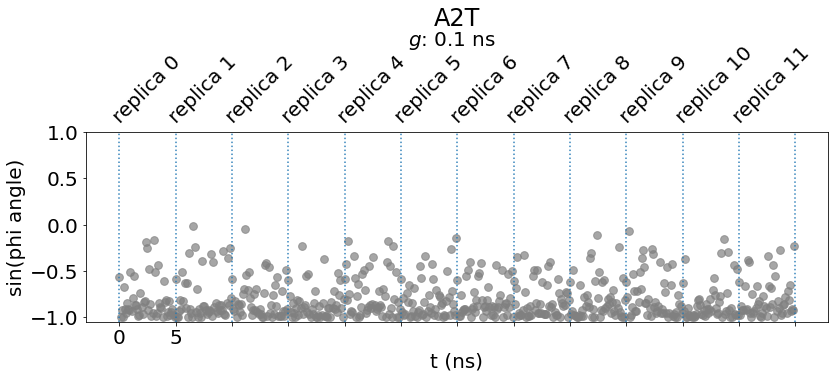

DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F1' = '/lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F2' = '/lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing

<Figure size 432x288 with 0 Axes>

DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


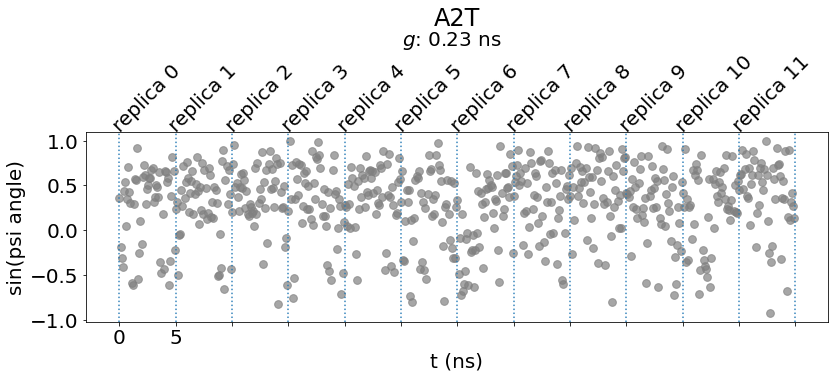

<Figure size 432x288 with 0 Axes>

In [11]:
check_phi_psi_sampling(out_dir, 
                     sub_dir, 
                     phase, 
                     n_replicas, 
                     n_iterations_start=0, 
                     n_iterations_end=51,
                     plot_name="A2T", 
                     y_range=[-1, 1.001])


# R2A (ACE-X-NME)

In [12]:
out_dir = "/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/46/7/replicate_0/"
sub_dir = 7
phase = 'apo'
n_replicas = 24

In [13]:
with open(os.path.join(out_dir, f"{sub_dir}_{phase}.pickle"), "rb") as f:
    htf = pickle.load(f)
    

In [5]:
for replica in range(21, n_replicas):
    make_traj(phase, out_dir, sub_dir, htf, replica_id=replica)

0 51


/scratch/lsftmp/13862322.tmpdir/ipykernel_67174/2791274735.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iteration in tqdm_notebook(range(n_iterations_start, n_iterations_end)):


  0%|          | 0/51 [00:00<?, ?it/s]

21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
saving old traj
saving new traj
0 51


  0%|          | 0/51 [00:00<?, ?it/s]

22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
saving old traj
saving new traj
0 51


  0%|          | 0/51 [00:00<?, ?it/s]

23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
saving old traj
saving new traj


DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F1' = '/lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F2' = '/lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing

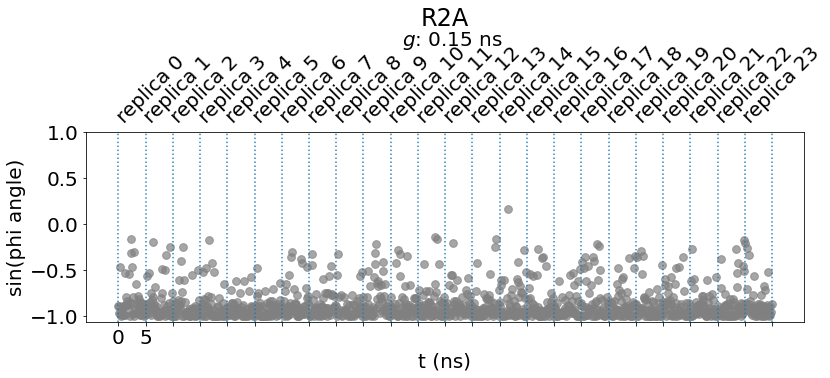

DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F1' = '/lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F2' = '/lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /lila/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing

<Figure size 432x288 with 0 Axes>

DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


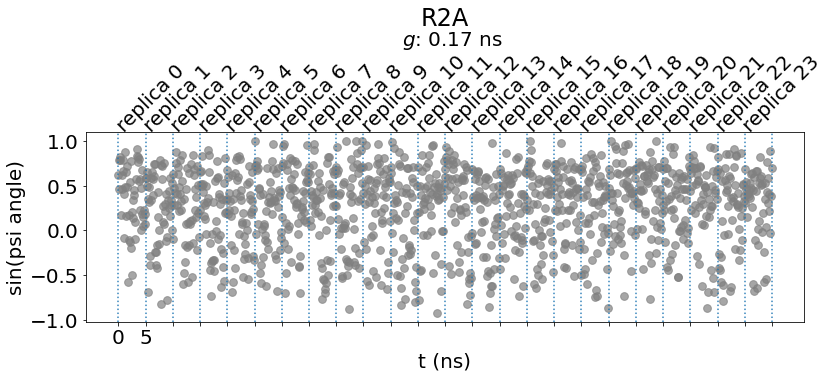

<Figure size 432x288 with 0 Axes>

In [14]:
check_phi_psi_sampling(out_dir, 
                     sub_dir, 
                     phase, 
                     n_replicas, 
                     n_iterations_start=0, 
                     n_iterations_end=51,
                     plot_name="R2A", 
                     y_range=[-1, 1.001])
